In [19]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [20]:
#choose device
if torch.cuda.is_available():
    device=torch.device('cuda')
else:
    device=torch.device('cpu')

In [ ]:
#define transform
train_transform=transforms.Compose(
    [transforms.Pad(4),
     transforms.RandomCrop(32),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485,0.456,0.406],
                          std=[0.229,0.224,0.225])])
valid_transform=transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485,0.456,0.406],
                          std=[0.229,0.224,0.225])])

In [ ]:
# download cifar-10 dataset
train_dataset=torchvision.datasets.CIFAR10(root='../data/',
                                           train=True,
                                           transform=train_transform,
                                           download=True)
test_dataset=torchvision.datasets.CIFAR10(root='../data/',
                                           train=False,
                                           transform=valid_transform,
                                           download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data/
Files already downloaded and verified


In [ ]:
# residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1=nn.Conv2d(in_channels=in_channels,out_channels=out_channels,stride=stride,kernel_size=3,padding=1,bias=False)
        self.bn1=nn.BatchNorm2d(out_channels)
        self.relu=nn.ReLU(inplace=True)
        self.conv2=nn.Conv2d(in_channels=out_channels,out_channels=out_channels,stride=1,kernel_size=3,padding=1,bias=False)
        self.bn2=nn.BatchNorm2d(out_channels)
        self.downsample=nn.Sequential()
        if (stride!=1) or(in_channels!=out_channels):
            self.downsample=nn.Sequential(
                nn.Conv2d(in_channels=in_channels,out_channels=out_channels,stride=stride,kernel_size=1,bias=False),
                nn.BatchNorm2d(out_channels))
    def forward(self,x):
        out=self.conv1(x)
        out=self.bn1(out)
        out=self.relu(out)
        out=self.conv2(out)
        out=self.bn2(out)
        out+=self.downsample(x)
        out=self.relu(out)
        return out
        

In [21]:
# 4-layer ResNet
class ResNet(nn.Module):
    def __init__(self,block,layers,num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels=80                                                  # 64 can be modified
        self.conv=nn.Conv2d(in_channels=3,out_channels=80,stride=1,kernel_size=3,padding=1,bias=False)
        self.bn=nn.BatchNorm2d(80)
        self.relu=nn.ReLU(inplace=True)
        self.layer1=self.make_layer(block, 80,layers[0], stride=1)        # 64 can be modified
        self.layer2=self.make_layer(block, 160, layers[1], stride=2)      # 128 can be modified
        self.layer3=self.make_layer(block, 320, layers[2], stride=2)      # 256 can be modified
        #self.layer4=self.make_layer(block, 512, layers[3], stride=2)      # 512 can be modified
        self.avg_pool=nn.AvgPool2d(8)                                        # 4 can be modified
        self.fc=nn.Linear(320,10) 
        
    def make_layer(self,block,out_channels,blocks, stride):
        layers=[]
        layers.append(block(self.in_channels,out_channels,stride))
        self.in_channels=out_channels
        for i in range(1,blocks):
            layers.append(block(out_channels,out_channels,stride=1))
        return nn.Sequential(*layers)
    
    def forward(self,x):
        out=self.conv(x)
        out=self.bn(out)
        out=self.relu(out)
        out=self.layer1(out)
        out=self.layer2(out)
        out=self.layer3(out)
        #out=self.layer4(out)
        out=self.avg_pool(out)
        out=out.view(out.size(0),-1)
        out=self.fc(out)
        return out

In [ ]:
his_lr=[]

In [ ]:
epochs=50
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=False)
model=ResNet(ResidualBlock,[3,3,2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.9, weight_decay=1e-3)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=50)
for i in range(epochs):
  optimizer.step()
  his_lr.append(optimizer.param_groups[-1]['lr'])
    #train_loss, train_acc=train(model)
    #test_acc=test(model)

    #print("Epoch %d. Train Loss %.4f. Train Acc %.4f. Test Acc %.4f."%(i,train_loss,train_acc,test_acc))
    
  #scheduler.step()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
print(his_lr)

[0.01, 0.009990133642141357, 0.009960573506572389, 0.009911436253643442, 0.009842915805643154, 0.009755282581475767, 0.009648882429441256, 0.009524135262330098, 0.009381533400219317, 0.009221639627510075, 0.009045084971874737, 0.008852566213878947, 0.008644843137107058, 0.008422735529643444, 0.00818711994874345, 0.007938926261462368, 0.007679133974894984, 0.007408768370508577, 0.0071288964578253644, 0.0068406227634233915, 0.006545084971874738, 0.006243449435824274, 0.005936906572928625, 0.005626666167821524, 0.005313952597646569, 0.005000000000000002, 0.004686047402353435, 0.004373333832178481, 0.0040630934270713785, 0.0037565505641757274, 0.0034549150281252662, 0.0031593772365766134, 0.0028711035421746384, 0.002591231629491424, 0.0023208660251050166, 0.0020610737385376356, 0.001812880051256552, 0.001577264470356557, 0.0013551568628929439, 0.0011474337861210548, 0.0009549150281252636, 0.000778360372489926, 0.0006184665997806823, 0.0004758647376699034, 0.0003511175705587434, 0.000244717

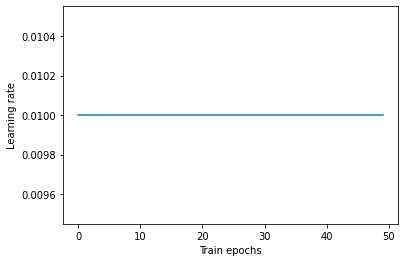

In [ ]:
x_list=list(range(len(his_lr)))
plt.plot(x_list,his_lr)

plt.xlabel('Train epochs')
plt.ylabel('Learning rate')
plt.show()

In [22]:
lr_001=np.array([0,1.4026,0.4848,0.5746,
 1,0.9012,0.6816,0.6711,
 2,0.7103,0.7525,0.7369,
 3,0.6023,0.7914,0.7948,
 4,0.5376,0.8138,0.8017,
 5,0.4794,0.8354,0.7912,
 6,0.4486,0.8449,0.7610,
 7,0.4222,0.8560,0.8357,
 8,0.3870,0.8688,0.8406,
 9,0.3643,0.8756,0.8606,
 10,0.3458,0.8820,0.8658,
 11,0.3306,0.8879,0.8526,
 12,0.3158,0.8928,0.8522,
 13,0.3002,0.8978,0.8546,
 14,0.2865,0.9032,0.8634,
 15,0.2770,0.9058,0.8312,
 16,0.2673,0.9087,0.8746,
 17,0.2650,0.9095,0.8447,
 18,0.2550,0.9132,0.8816,
 19,0.2536,0.9146,0.8798,
 20,0.2413,0.9181,0.8839,
 21,0.2416,0.9181,0.8702,
 22,0.2366,0.9201,0.8846,
 23,0.2316,0.9224,0.8206,
 24,0.2293,0.9229,0.8877,
 25,0.2271,0.9232,0.8808,
 26,0.2229,0.9240,0.8745,
 27,0.2183,0.9259,0.8812,
 28,0.2133,0.9277,0.8893,
 29,0.2128,0.9289,0.8724,
 30,0.2069,0.9302,0.8651,
 31,0.2042,0.9320,0.8902,
 32,0.2043,0.9316,0.8753,
 33,0.2013,0.9321,0.8873,
 34,0.1988,0.9320,0.8938,
 35,0.1971,0.9342,0.8897,
 36,0.1981,0.9324,0.8666,
 37,0.1958,0.9345,0.8989,
 38,0.1923,0.9359,0.8837,
 39,0.1866,0.9385,0.8762,
 40,0.1884,0.9372,0.8782,
 41,0.1800,0.9395,0.8734,
 42,0.1880,0.9352,0.8888,
 43,0.1840,0.9393,0.8912,
 44,0.1860,0.9384,0.8961,
 45,0.1770,0.9407,0.8848,
 46,0.1780,0.9396,0.8755,
 47,0.1740,0.9423,0.8940,
 48,0.1799,0.9387,0.8952,
 49,0.1760,0.9418,0.8868
])


In [23]:
lr_001=lr_001.reshape(50,4)

In [24]:
lr_001=lr_001.T

In [ ]:
lr_001

array([[ 0.    ,  1.    ,  2.    ,  3.    ,  4.    ,  5.    ,  6.    ,
         7.    ,  8.    ,  9.    , 10.    , 11.    , 12.    , 13.    ,
        14.    , 15.    , 16.    , 17.    , 18.    , 19.    , 20.    ,
        21.    , 22.    , 23.    , 24.    , 25.    , 26.    , 27.    ,
        28.    , 29.    , 30.    , 31.    , 32.    , 33.    , 34.    ,
        35.    , 36.    , 37.    , 38.    , 39.    , 40.    , 41.    ,
        42.    , 43.    , 44.    , 45.    , 46.    , 47.    , 48.    ,
        49.    ],
       [ 1.4026,  0.9012,  0.7103,  0.6023,  0.5376,  0.4794,  0.4486,
         0.4222,  0.387 ,  0.3643,  0.3458,  0.3306,  0.3158,  0.3002,
         0.2865,  0.277 ,  0.2673,  0.265 ,  0.255 ,  0.2536,  0.2413,
         0.2416,  0.2366,  0.2316,  0.2293,  0.2271,  0.2229,  0.2183,
         0.2133,  0.2128,  0.2069,  0.2042,  0.2043,  0.2013,  0.1988,
         0.1971,  0.1981,  0.1958,  0.1923,  0.1866,  0.1884,  0.18  ,
         0.188 ,  0.184 ,  0.186 ,  0.177 ,  0.178 ,  0.174

In [ ]:
lr_0005=np.array([0,1.3664,0.4952,0.5679,
1,0.9320,0.6697,0.6670,
2,0.7361,0.7426,0.7165,
3,0.6222,0.7852,0.7794,
4,0.5479,0.8102,0.7974,
5,0.4933,0.8317,0.8038,
6,0.4513,0.8420,0.8286,
7,0.4152,0.8567,0.8145,
8,0.3828,0.8677,0.8599,
9,0.3624,0.8764,0.8343,
10,0.3341,0.8858,0.8608,
11,0.3238,0.8876,0.8527,
12,0.3073,0.8937,0.8090,
13,0.2855,0.9021,0.8680,
14,0.2729,0.9067,0.8678,
15,0.2611,0.9112,0.8710,
16,0.2481,0.9163,0.8507,
17,0.2420,0.9184,0.8706,
18,0.2301,0.9233,0.8735,
19,0.2232,0.9236,0.8819,
20,0.2138,0.9266,0.8823,
21,0.1998,0.9320,0.8906,
22,0.1976,0.9332,0.8808,
23,0.1957,0.9327,0.8918,
24,0.1808,0.9388,0.8883,
25,0.1789,0.9399,0.8851,
26,0.1750,0.9413,0.8622,
27,0.1711,0.9413,0.8963,
28,0.1656,0.9456,0.8959,
29,0.1615,0.9456,0.8905,
30,0.1571,0.9466,0.8726,
31,0.1480,0.9504,0.8862,
32,0.1469,0.9511,0.8947,
33,0.1499,0.9497,0.8928,
34,0.1411,0.9533,0.8973,
35,0.1379,0.9546,0.9079,
36,0.1366,0.9556,0.9021,
37,0.1348,0.9558,0.8962,
38,0.1287,0.9579,0.9069,
39,0.1296,0.9569,0.8995,
40,0.1265,0.9584,0.9094,
41,0.1334,0.9558,0.8982,
42,0.1277,0.9582,0.9045,
43,0.1273,0.9575,0.8886,
44,0.1243,0.9591,0.9002,
45,0.1244,0.9584,0.8628,
46,0.1202,0.9608,0.9025,
47,0.1281,0.9579,0.9008,
48,0.1238,0.9595,0.8894,
49,0.1207,0.9601,0.9050

    
])

In [ ]:
lr_0005=lr_0005.reshape(50,4)
lr_0005=lr_0005.T

In [ ]:
lr_0003=np.array([
     0 ,1.3826 ,0.4929 ,0.5613,
 1 ,0.9422 ,0.6646 ,0.5827,
 2 ,0.7507 ,0.7371 ,0.7255,
 3 ,0.6384 ,0.7795 ,0.7579,
 4 ,0.5543 ,0.8069 ,0.7845,
 5 ,0.5028 ,0.8269 ,0.7878,
 6 ,0.4599 ,0.8423 ,0.8052,
 7 ,0.4243 ,0.8537 ,0.8039,
 8 ,0.3958 ,0.8642 ,0.8433,
 9 ,0.3694 ,0.8743 ,0.8188,
 10 ,0.3475 ,0.8806 ,0.8249,
 11 ,0.3271 ,0.8873 ,0.8569,
 12 ,0.3088 ,0.8938 ,0.8472,
 13 ,0.2919 ,0.8989 ,0.8382,
 14 ,0.2767 ,0.9041 ,0.8535,
 15 ,0.2629 ,0.9103 ,0.8488,
 16 ,0.2536 ,0.9136 ,0.8475,
 17 ,0.2419 ,0.9174 ,0.8713,
 18 ,0.2304 ,0.9218 ,0.8687,
 19 ,0.2208 ,0.9248 ,0.8869,
 20 ,0.2090 ,0.9283 ,0.8377,
 21 ,0.2026 ,0.9305 ,0.8676,
 22 ,0.1926 ,0.9354 ,0.8661,
 23 ,0.1888 ,0.9350 ,0.8765,
 24 ,0.1799 ,0.9386 ,0.8847,
 25 ,0.1719 ,0.9414 ,0.8840,
 26 ,0.1688 ,0.9433 ,0.8904,
 27 ,0.1638 ,0.9440 ,0.8922,
 28 ,0.1538 ,0.9485 ,0.8832,
 29 ,0.1517 ,0.9492 ,0.8956,
 30 ,0.1445 ,0.9515 ,0.8987,
 31 ,0.1358 ,0.9551 ,0.8867,
 32 ,0.1343 ,0.9554 ,0.8893,
 33 ,0.1330 ,0.9569 ,0.9070,
 34 ,0.1286 ,0.9576 ,0.8921,
 35 ,0.1250 ,0.9584 ,0.8884,
 36 ,0.1183 ,0.9614 ,0.8988,
 37 ,0.1180 ,0.9619 ,0.8939,
 38 ,0.1169 ,0.9616 ,0.8973,
 39 ,0.1120 ,0.9635 ,0.8885,
 40 ,0.1101 ,0.9638 ,0.8836,
 41 ,0.1076 ,0.9651 ,0.8893,
 42 ,0.1043 ,0.9668 ,0.9105,
 43 ,0.0983 ,0.9680 ,0.8997,
 44 ,0.0995 ,0.9677 ,0.8992,
 45 ,0.0928 ,0.9698 ,0.8992,
 46 ,0.0922 ,0.9709 ,0.8895,
 47 ,0.0895 ,0.9723 ,0.9062,
 48 ,0.0933 ,0.9705 ,0.8899,
 49 ,0.0929 ,0.9702 ,0.9043
])

In [ ]:
lr_0003=lr_0003.reshape(50,4)
lr_0003=lr_0003.T

In [ ]:
lr_0001=np.array([
    0 ,1.5060 ,0.4480 ,0.5367,
1 ,1.0856 ,0.6114 ,0.6349,
2 ,0.9021 ,0.6819 ,0.6535,
3 ,0.7793 ,0.7257 ,0.7229,
4 ,0.6854 ,0.7621 ,0.6907,
5 ,0.6221 ,0.7853 ,0.7760,
6 ,0.5648 ,0.8055 ,0.7893,
7 ,0.5264 ,0.8167 ,0.7470,
8 ,0.4864 ,0.8331 ,0.8253,
9 ,0.4562 ,0.8419 ,0.8133,
10 ,0.4274 ,0.8537 ,0.8214,
11 ,0.4086 ,0.8598 ,0.8224,
12 ,0.3838 ,0.8687 ,0.8378,
13 ,0.3620 ,0.8757 ,0.8401,
14 ,0.3490 ,0.8795 ,0.8447,
15 ,0.3335 ,0.8848 ,0.8132,
16 ,0.3169 ,0.8916 ,0.8600,
17 ,0.3003 ,0.8965 ,0.8568,
18 ,0.2851 ,0.9025 ,0.8579,
19 ,0.2760 ,0.9060 ,0.8306,
20 ,0.2652 ,0.9100 ,0.8309,
21 ,0.2563 ,0.9127 ,0.8677,
22 ,0.2480 ,0.9145 ,0.8716,
23 ,0.2364 ,0.9203 ,0.8348,
24 ,0.2250 ,0.9226 ,0.8733,
25 ,0.2147 ,0.9263 ,0.8784,
26 ,0.2096 ,0.9285 ,0.8751,
27 ,0.2023 ,0.9308 ,0.8784,
28 ,0.1945 ,0.9327 ,0.8767,
29 ,0.1875 ,0.9352 ,0.8714,
30 ,0.1751 ,0.9394 ,0.8663,
31 ,0.1767 ,0.9386 ,0.8636,
32 ,0.1690 ,0.9422 ,0.8711,
33 ,0.1608 ,0.9446 ,0.8790,
34 ,0.1578 ,0.9467 ,0.8775,
35 ,0.1481 ,0.9499 ,0.8821,
36 ,0.1447 ,0.9510 ,0.8850,
37 ,0.1412 ,0.9525 ,0.8848,
38 ,0.1343 ,0.9550 ,0.8866,
39 ,0.1321 ,0.9557 ,0.8509,
40 ,0.1249 ,0.9577 ,0.8625,
41 ,0.1231 ,0.9591 ,0.8862,
42 ,0.1227 ,0.9599 ,0.8933,
43 ,0.1183 ,0.9607 ,0.8834,
44 ,0.1090 ,0.9639 ,0.8826,
45 ,0.1093 ,0.9635 ,0.8837,
46 ,0.1078 ,0.9641 ,0.8844,
47 ,0.1030 ,0.9653 ,0.8797,
48 ,0.0974 ,0.9679 ,0.8986,
49 ,0.0939 ,0.9695 ,0.8920

])

In [ ]:
lr_0001=lr_0001.reshape(50,4)
lr_0001=lr_0001.T

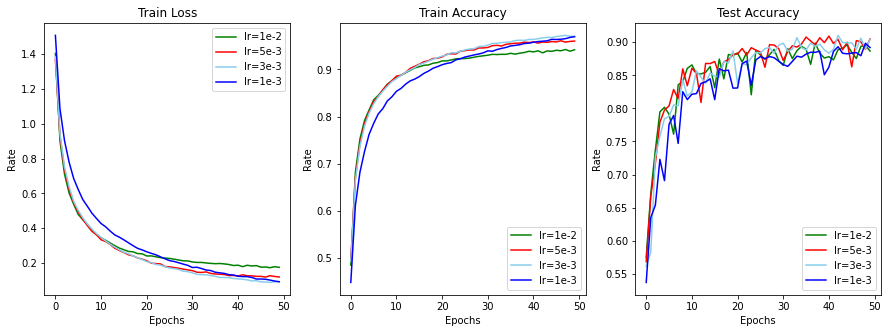

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)

plt.title('Train Loss')
plt.plot(lr_001[0],lr_001[1],color='green',label='lr=1e-2')
plt.plot(lr_0005[0],lr_0005[1],color='red',label='lr=5e-3')
plt.plot(lr_0003[0],lr_0003[1],color='skyblue',label='lr=3e-3')
plt.plot(lr_0001[0],lr_0001[1],color='blue',label='lr=1e-3')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Rate')

plt.subplot(1,3,2)

plt.title('Train Accuracy')
plt.plot(lr_001[0],lr_001[2],color='green',label='lr=1e-2')
plt.plot(lr_0005[0],lr_0005[2],color='red',label='lr=5e-3')
plt.plot(lr_0003[0],lr_0003[2],color='skyblue',label='lr=3e-3')
plt.plot(lr_0001[0],lr_0001[2],color='blue',label='lr=1e-3')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Rate')

plt.subplot(1,3,3)

plt.title('Test Accuracy')
plt.plot(lr_001[0],lr_001[3],color='green',label='lr=1e-2')
plt.plot(lr_0005[0],lr_0005[3],color='red',label='lr=5e-3')
plt.plot(lr_0003[0],lr_0003[3],color='skyblue',label='lr=3e-3')
plt.plot(lr_0001[0],lr_0001[3],color='blue',label='lr=1e-3')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Rate')

plt.show()

In [ ]:
bs_32=np.array([
    0,1.4754,0.4589,0.5893,
1,0.9641,0.6577,0.6951,
2,0.7557,0.7366,0.7561,
3,0.6386,0.7780,0.7790,
4,0.5705,0.8047,0.7976,
5,0.5221,0.8215,0.8095,
6,0.4798,0.8358,0.8236,
7,0.4516,0.8461,0.8434,
8,0.4241,0.8560,0.8343,
9,0.4076,0.8607,0.8509,
10,0.3897,0.8674,0.7969,
11,0.3752,0.8738,0.8405,
12,0.3564,0.8785,0.8540,
13,0.3476,0.8823,0.8609,
14,0.3368,0.8863,0.8684,
15,0.3226,0.8908,0.8715,
16,0.3128,0.8932,0.8682,
17,0.3020,0.8967,0.8616,
18,0.2936,0.9009,0.8758,
19,0.2768,0.9083,0.8711,
20,0.2654,0.9098,0.8640,
21,0.2550,0.9130,0.8784,
22,0.2434,0.9174,0.8867,
23,0.2314,0.9211,0.8993,
24,0.2221,0.9257,0.8988,
25,0.2091,0.9303,0.9068,
26,0.1991,0.9335,0.8887,
27,0.1841,0.9402,0.9098,
28,0.1713,0.9417,0.8983,
29,0.1576,0.9484,0.9080,
30,0.1476,0.9516,0.9075,
31,0.1330,0.9583,0.9171,
32,0.1168,0.9627,0.9165,
33,0.1049,0.9671,0.9176,
34,0.0907,0.9724,0.9260,
35,0.0798,0.9762,0.9292,
36,0.0661,0.9813,0.9308,
37,0.0580,0.9838,0.9303,
38,0.0462,0.9886,0.9373,
39,0.0380,0.9912,0.9387,
40,0.0312,0.9940,0.9373,
41,0.0256,0.9957,0.9378,
42,0.0228,0.9966,0.9397,
43,0.0212,0.9967,0.9417,
44,0.0179,0.9979,0.9431,
45,0.0170,0.9979,0.9434,
46,0.0157,0.9984,0.9444,
47,0.0154,0.9984,0.9430,
48,0.0148,0.9987,0.9444,
49,0.0140,0.9988,0.9449
])

In [ ]:
bs_32=bs_32.reshape(50,4)
bs_32=bs_32.T

In [ ]:
bs_64=np.array([
    0,1.4131,0.4806,0.5871
,1,0.9205,0.6712,0.6487
,2,0.7130,0.7510,0.7277
,3,0.6116,0.7882,0.7957
,4,0.5396,0.8151,0.8033
,5,0.4837,0.8311,0.8154
,6,0.4418,0.8481,0.8107
,7,0.4113,0.8607,0.8040
,8,0.3786,0.8720,0.8253
,9,0.3559,0.8776,0.8305
,10,0.3356,0.8852,0.8565
,11,0.3158,0.8928,0.8327
,12,0.2996,0.8984,0.8448
,13,0.2816,0.9039,0.8663
,14,0.2654,0.9096,0.8794
,15,0.2526,0.9148,0.8692
,16,0.2389,0.9194,0.8969
,17,0.2254,0.9245,0.8619
,18,0.2172,0.9275,0.8765
,19,0.2045,0.9305,0.8785
,20,0.1923,0.9351,0.8964
,21,0.1788,0.9394,0.8928
,22,0.1681,0.9447,0.8860
,23,0.1572,0.9479,0.9036
,24,0.1538,0.9483,0.8992
,25,0.1381,0.9546,0.8984
,26,0.1254,0.9588,0.8992
,27,0.1138,0.9640,0.8971
,28,0.1033,0.9672,0.9151
,29,0.0923,0.9717,0.9070
,30,0.0862,0.9732,0.9176
,31,0.0708,0.9797,0.9201
,32,0.0631,0.9824,0.9189
,33,0.0529,0.9854,0.9214
,34,0.0437,0.9889,0.9254
,35,0.0375,0.9912,0.9284
,36,0.0303,0.9938,0.9306
,37,0.0251,0.9954,0.9310
,38,0.0221,0.9961,0.9351
,39,0.0192,0.9972,0.9340
,40,0.0162,0.9981,0.9363
,41,0.0155,0.9980,0.9354
,42,0.0135,0.9987,0.9383
,43,0.0136,0.9986,0.9384
,44,0.0121,0.9990,0.9383
,45,0.0113,0.9991,0.9383
,46,0.0115,0.9991,0.9379
,47,0.0112,0.9991,0.9384
,48,0.0107,0.9994,0.9383
,49,0.0106,0.9993,0.9387
])

In [ ]:
bs_64=bs_64.reshape(50,4)
bs_64=bs_64.T


In [ ]:
bs_128=np.array([
    0,1.4114,0.4800,0.5831
,1,0.9495,0.6626,0.6237
,2,0.7475,0.7354,0.7201
,3,0.6273,0.7820,0.7251
,4,0.5532,0.8089,0.7285
,5,0.4981,0.8286,0.7447
,6,0.4459,0.8462,0.8236
,7,0.4111,0.8584,0.8104
,8,0.3802,0.8682,0.8293
,9,0.3525,0.8787,0.8318
,10,0.3305,0.8863,0.8122
,11,0.3067,0.8952,0.8556
,12,0.2869,0.9008,0.8286
,13,0.2676,0.9084,0.8469
,14,0.2522,0.9127,0.8673
,15,0.2379,0.9189,0.8737
,16,0.2238,0.9230,0.8779
,17,0.2066,0.9300,0.8784
,18,0.2004,0.9320,0.8760
,19,0.1812,0.9393,0.8523
,20,0.1720,0.9418,0.8827
,21,0.1597,0.9461,0.9025
,22,0.1464,0.9519,0.8758
,23,0.1365,0.9547,0.8805
,24,0.1252,0.9594,0.9017
,25,0.1113,0.9643,0.9080
,26,0.1029,0.9675,0.8913
,27,0.0939,0.9708,0.8882
,28,0.0822,0.9746,0.9109
,29,0.0780,0.9762,0.9087
,30,0.0671,0.9802,0.9137
,31,0.0584,0.9836,0.9174
,32,0.0487,0.9868,0.9197
,33,0.0434,0.9891,0.9224
,34,0.0358,0.9923,0.9226
,35,0.0321,0.9937,0.9260
,36,0.0280,0.9947,0.9272
,37,0.0237,0.9963,0.9233
,38,0.0213,0.9968,0.9299
,39,0.0188,0.9978,0.9288
,40,0.0182,0.9978,0.9301
,41,0.0166,0.9983,0.9319
,42,0.0153,0.9988,0.9312
,43,0.0147,0.9987,0.9323
,44,0.0142,0.9987,0.9330
,45,0.0138,0.9988,0.9321
,46,0.0137,0.9989,0.9318
,47,0.0130,0.9991,0.9328
,48,0.0130,0.9990,0.9321
,49,0.0130,0.9991,0.9326
])

In [ ]:
bs_128=bs_128.reshape(50,4)
bs_128=bs_128.T

In [ ]:
bs_256=np.array([
    0,1.4716,0.4585,0.4888
,1,1.0036,0.6441,0.6290
,2,0.7989,0.7166,0.7186
,3,0.6653,0.7686,0.6562
,4,0.5907,0.7960,0.6251
,5,0.5246,0.8198,0.7783
,6,0.4733,0.8375,0.8073
,7,0.4272,0.8531,0.7735
,8,0.3966,0.8637,0.8259
,9,0.3666,0.8733,0.8123
,10,0.3454,0.8823,0.8162
,11,0.3209,0.8890,0.8444
,12,0.2977,0.8980,0.8296
,13,0.2846,0.9022,0.8142
,14,0.2597,0.9104,0.8334
,15,0.2453,0.9159,0.7631
,16,0.2328,0.9208,0.8548
,17,0.2155,0.9267,0.8540
,18,0.2075,0.9293,0.8494
,19,0.1913,0.9331,0.8392
,20,0.1799,0.9387,0.8511
,21,0.1642,0.9445,0.8748
,22,0.1523,0.9477,0.8435
,23,0.1430,0.9518,0.8937
,24,0.1303,0.9568,0.8711
,25,0.1253,0.9586,0.8768
,26,0.1128,0.9634,0.8902
,27,0.1023,0.9674,0.8938
,28,0.0914,0.9720,0.9039
,29,0.0823,0.9744,0.8964
,30,0.0741,0.9780,0.8999
,31,0.0663,0.9808,0.9108
,32,0.0604,0.9829,0.9022
,33,0.0529,0.9858,0.9046
,34,0.0473,0.9882,0.9144
,35,0.0415,0.9903,0.9163
,36,0.0378,0.9921,0.9128
,37,0.0342,0.9933,0.9174
,38,0.0308,0.9943,0.9186
,39,0.0277,0.9958,0.9206
,40,0.0269,0.9956,0.9201
,41,0.0249,0.9963,0.9220
,42,0.0236,0.9967,0.9219
,43,0.0225,0.9971,0.9218
,44,0.0219,0.9971,0.9231
,45,0.0210,0.9972,0.9224
,46,0.0206,0.9976,0.9226
,47,0.0206,0.9975,0.9225
,48,0.0196,0.9981,0.9222
,49,0.0199,0.9979,0.9231

]
)

In [ ]:
bs_256=bs_256.reshape(50,4)
bs_256=bs_256.T

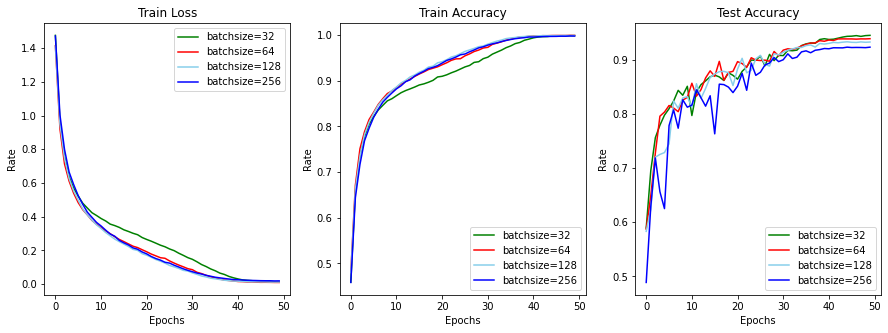

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)

plt.title('Train Loss')
plt.plot(bs_32[0],bs_32[1],color='green',label='batchsize=32')
plt.plot(bs_64[0],bs_64[1],color='red',label='batchsize=64')
plt.plot(bs_128[0],bs_128[1],color='skyblue',label='batchsize=128')
plt.plot(bs_256[0],bs_256[1],color='blue',label='batchsize=256')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Rate')

plt.subplot(1,3,2)

plt.title('Train Accuracy')
plt.plot(bs_32[0],bs_32[2],color='green',label='batchsize=32')
plt.plot(bs_64[0],bs_64[2],color='red',label='batchsize=64')
plt.plot(bs_128[0],bs_128[2],color='skyblue',label='batchsize=128')
plt.plot(bs_256[0],bs_256[2],color='blue',label='batchsize=256')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Rate')

plt.subplot(1,3,3)

plt.title('Test Accuracy')
plt.plot(bs_32[0],bs_32[3],color='green',label='batchsize=32')
plt.plot(bs_64[0],bs_64[3],color='red',label='batchsize=64')
plt.plot(bs_128[0],bs_128[3],color='skyblue',label='batchsize=128')
plt.plot(bs_256[0],bs_256[3],color='blue',label='batchsize=256')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Rate')

plt.show()

In [ ]:
bs_64_lr2=np.array([
    0,1.4601,0.4611,0.6085
,1,0.9619,0.6569,0.7030
,2,0.7634,0.7327,0.7294
,3,0.6483,0.7754,0.7866
,4,0.5761,0.8015,0.7907
,5,0.5165,0.8245,0.7803
,6,0.4748,0.8377,0.8232
,7,0.4463,0.8479,0.8335
,8,0.4222,0.8549,0.7679
,9,0.3991,0.8632,0.8430
,10,0.3833,0.8695,0.8530
,11,0.3696,0.8721,0.7994
,12,0.3557,0.8785,0.8431
,13,0.3410,0.8835,0.8479
,14,0.3247,0.8898,0.8454
,15,0.3202,0.8904,0.8596
,16,0.3039,0.8967,0.8521
,17,0.2972,0.8982,0.8766
,18,0.2820,0.9056,0.8614
,19,0.2739,0.9062,0.8618
,20,0.2609,0.9108,0.8599
,21,0.2431,0.9182,0.8546
,22,0.2375,0.9203,0.8669
,23,0.2251,0.9242,0.8857
,24,0.2153,0.9280,0.8538
,25,0.2053,0.9317,0.8906
,26,0.1862,0.9378,0.8907
,27,0.1770,0.9409,0.8872
,28,0.1646,0.9447,0.9048
,29,0.1566,0.9478,0.8952
,30,0.1377,0.9548,0.9021
,31,0.1212,0.9616,0.9112
,32,0.1095,0.9660,0.9145
,33,0.0974,0.9696,0.9171
,34,0.0803,0.9761,0.9219
,35,0.0700,0.9794,0.9209
,36,0.0582,0.9839,0.9316
,37,0.0471,0.9877,0.9279
,38,0.0386,0.9912,0.9352
,39,0.0305,0.9938,0.9352
,40,0.0246,0.9954,0.9399
,41,0.0209,0.9967,0.9412
,42,0.0172,0.9980,0.9402
,43,0.0160,0.9981,0.9445
,44,0.0150,0.9984,0.9432
,45,0.0129,0.9989,0.9434
,46,0.0128,0.9990,0.9423
,47,0.0118,0.9992,0.9435
,48,0.0120,0.9993,0.9436
,49,0.0122,0.9988,0.9439
])

In [ ]:
bs_64_lr2=bs_64_lr2.reshape(50,4)
bs_64_lr2=bs_64_lr2.T

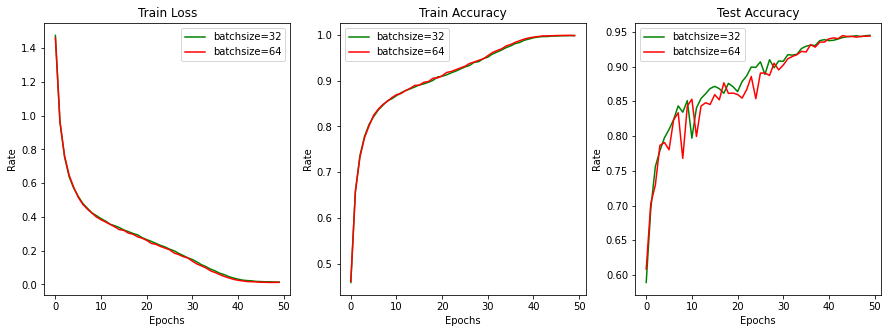

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)

plt.title('Train Loss')
plt.plot(bs_32[0],bs_32[1],color='green',label='batchsize=32')
plt.plot(bs_64_lr2[0],bs_64_lr2[1],color='red',label='batchsize=64')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Rate')

plt.subplot(1,3,2)

plt.title('Train Accuracy')
plt.plot(bs_32[0],bs_32[2],color='green',label='batchsize=32')
plt.plot(bs_64_lr2[0],bs_64_lr2[2],color='red',label='batchsize=64')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Rate')

plt.subplot(1,3,3)

plt.title('Test Accuracy')
plt.plot(bs_32[0],bs_32[3],color='green',label='batchsize=32')
plt.plot(bs_64_lr2[0],bs_64_lr2[3],color='red',label='batchsize=64')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Rate')

plt.show()

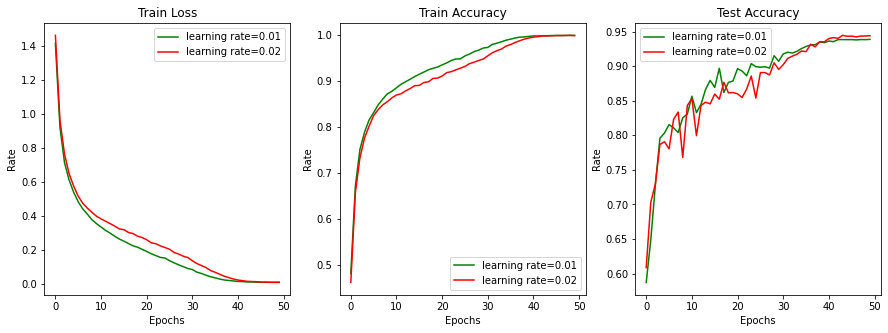

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)

plt.title('Train Loss')
plt.plot(bs_64[0],bs_64[1],color='green',label='learning rate=0.01')
plt.plot(bs_64_lr2[0],bs_64_lr2[1],color='red',label='learning rate=0.02')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Rate')

plt.subplot(1,3,2)

plt.title('Train Accuracy')
plt.plot(bs_64[0],bs_64[2],color='green',label='learning rate=0.01')
plt.plot(bs_64_lr2[0],bs_64_lr2[2],color='red',label='learning rate=0.02')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Rate')

plt.subplot(1,3,3)

plt.title('Test Accuracy')
plt.plot(bs_64[0],bs_64[3],color='green',label='learning rate=0.01')
plt.plot(bs_64_lr2[0],bs_64_lr2[3],color='red',label='learning rate=0.02')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Rate')

plt.show()

In [ ]:
best=np.array([
    0,1.4395,0.4736,0.6055
,1,0.9420,0.6674,0.7046
,2,0.7441,0.7413,0.7686
,3,0.6394,0.7793,0.7664
,4,0.5721,0.8031,0.7944
,5,0.5170,0.8227,0.7979
,6,0.4716,0.8400,0.8231
,7,0.4408,0.8487,0.8312
,8,0.4172,0.8570,0.8459
,9,0.3969,0.8664,0.8314
,10,0.3777,0.8728,0.8508
,11,0.3624,0.8755,0.8533
,12,0.3525,0.8800,0.8675
,13,0.3338,0.8855,0.8705
,14,0.3202,0.8921,0.8592
,15,0.3098,0.8952,0.8749
,16,0.2958,0.8986,0.8753
,17,0.2853,0.9022,0.8718
,18,0.2753,0.9059,0.8753
,19,0.2650,0.9106,0.8659
,20,0.2523,0.9148,0.8776
,21,0.2392,0.9195,0.8891
,22,0.2280,0.9224,0.8948
,23,0.2142,0.9279,0.8918
,24,0.2029,0.9311,0.8842
,25,0.1907,0.9361,0.8985
,26,0.1791,0.9410,0.9093
,27,0.1655,0.9460,0.9100
,28,0.1520,0.9504,0.9140
,29,0.1449,0.9517,0.9004
,30,0.1254,0.9606,0.9218
,31,0.1140,0.9634,0.9216
,32,0.1015,0.9682,0.9228
,33,0.0908,0.9723,0.9274
,34,0.0757,0.9776,0.9264
,35,0.0652,0.9814,0.9259
,36,0.0492,0.9868,0.9360
,37,0.0403,0.9901,0.9407
,38,0.0312,0.9931,0.9425
,39,0.0259,0.9952,0.9477
,40,0.0194,0.9970,0.9490
,41,0.0170,0.9974,0.9495
,42,0.0148,0.9981,0.9478
,43,0.0127,0.9987,0.9521
,44,0.0119,0.9990,0.9511
,45,0.0109,0.9991,0.9516
,46,0.0109,0.9989,0.9529
,47,0.0099,0.9993,0.9528
,48,0.0101,0.9993,0.9515
,49,0.0097,0.9994,0.9518

])

In [ ]:
best=best.reshape(50,4)
best=best.T

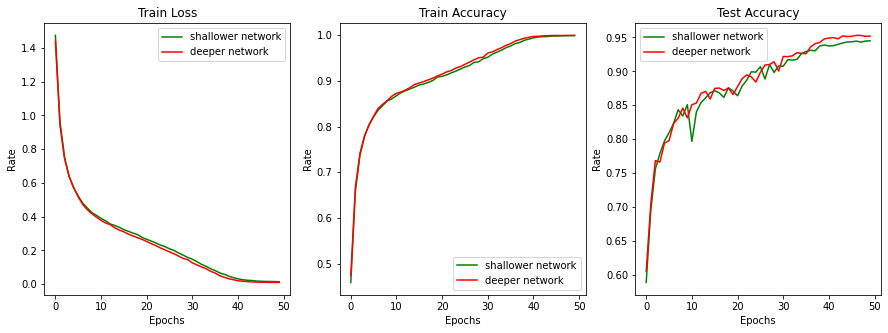

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)

plt.title('Train Loss')
plt.plot(bs_32[0],bs_32[1],color='green',label='shallower network')
plt.plot(best[0],best[1],color='red',label='deeper network')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Rate')

plt.subplot(1,3,2)

plt.title('Train Accuracy')
plt.plot(bs_32[0],bs_32[2],color='green',label='shallower network')
plt.plot(best[0],best[2],color='red',label='deeper network')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Rate')

plt.subplot(1,3,3)

plt.title('Test Accuracy')
plt.plot(bs_32[0],bs_32[3],color='green',label='shallower network')
plt.plot(best[0],best[3],color='red',label='deeper network')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Rate')

plt.show()

In [ ]:
bs_64new=np.array([
    0,1.4893,0.4510,0.5266
,1,0.9747,0.6540,0.6248
,2,0.7475,0.7405,0.7687
,3,0.6366,0.7796,0.7472
,4,0.5560,0.8098,0.7942
,5,0.5079,0.8258,0.8187
,6,0.4647,0.8416,0.7785
,7,0.4345,0.8500,0.8286
,8,0.4109,0.8597,0.8166
,9,0.3892,0.8684,0.8259
,10,0.3726,0.8721,0.8246
,11,0.3561,0.8790,0.8371
,12,0.3439,0.8831,0.8512
,13,0.3251,0.8897,0.8491
,14,0.3171,0.8913,0.8451
,15,0.3032,0.8963,0.8344
,16,0.2904,0.9016,0.8634
,17,0.2772,0.9048,0.8551
,18,0.2684,0.9069,0.8674
,19,0.2574,0.9129,0.8711
,20,0.2387,0.9188,0.8704
,21,0.2301,0.9217,0.8976
,22,0.2161,0.9278,0.8799
,23,0.2111,0.9283,0.8819
,24,0.1987,0.9336,0.8874
,25,0.1777,0.9402,0.8851
,26,0.1688,0.9434,0.8823
,27,0.1537,0.9503,0.8913
,28,0.1489,0.9508,0.9012
,29,0.1302,0.9584,0.9156
,30,0.1228,0.9614,0.9182
,31,0.1051,0.9664,0.9153
,32,0.0924,0.9701,0.9169
,33,0.0795,0.9759,0.9222
,34,0.0637,0.9815,0.9253
,35,0.0570,0.9841,0.9322
,36,0.0436,0.9887,0.9324
,37,0.0345,0.9920,0.9379
,38,0.0261,0.9948,0.9408
,39,0.0203,0.9965,0.9435
,40,0.0174,0.9975,0.9458
,41,0.0139,0.9983,0.9474
,42,0.0116,0.9989,0.9474
,43,0.0110,0.9990,0.9477
,44,0.0091,0.9995,0.9475
,45,0.0088,0.9995,0.9477
,46,0.0085,0.9997,0.9477
,47,0.0081,0.9996,0.9483
,48,0.0081,0.9995,0.9473
,49,0.0080,0.9996,0.9488

])

In [ ]:
bs_64new=bs_64new.reshape(50,4)
bs_64new=bs_64new.T

In [ ]:
bs_128new=np.array([
    0,1.5500,0.4239,0.5412
,1,1.0380,0.6266,0.6440
,2,0.8067,0.7174,0.6652
,3,0.6657,0.7677,0.7159
,4,0.5781,0.8008,0.7537
,5,0.5194,0.8194,0.8079
,6,0.4855,0.8328,0.7793
,7,0.4423,0.8481,0.8067
,8,0.4104,0.8601,0.7995
,9,0.3903,0.8671,0.8343
,10,0.3714,0.8735,0.8535
,11,0.3595,0.8778,0.8358
,12,0.3418,0.8851,0.8424
,13,0.3324,0.8876,0.8488
,14,0.3185,0.8915,0.8685
,15,0.3034,0.8965,0.8445
,16,0.2900,0.8998,0.8589
,17,0.2727,0.9077,0.8531
,18,0.2702,0.9087,0.8207
,19,0.2530,0.9130,0.8561
,20,0.2416,0.9182,0.8398
,21,0.2266,0.9234,0.8520
,22,0.2157,0.9267,0.8838
,23,0.2067,0.9304,0.8871
,24,0.1911,0.9353,0.8630
,25,0.1785,0.9404,0.8709
,26,0.1672,0.9442,0.8733
,27,0.1545,0.9479,0.8871
,28,0.1405,0.9541,0.8990
,29,0.1306,0.9585,0.8755
,30,0.1164,0.9621,0.8920
,31,0.1042,0.9656,0.9106
,32,0.0886,0.9715,0.9115
,33,0.0805,0.9754,0.9228
,34,0.0631,0.9813,0.9295
,35,0.0486,0.9866,0.9241
,36,0.0381,0.9902,0.9330
,37,0.0314,0.9925,0.9273
,38,0.0224,0.9958,0.9425
,39,0.0171,0.9973,0.9391
,40,0.0137,0.9983,0.9451
,41,0.0117,0.9989,0.9451
,42,0.0105,0.9990,0.9465
,43,0.0092,0.9993,0.9461
,44,0.0083,0.9994,0.9463
,45,0.0081,0.9995,0.9477
,46,0.0075,0.9997,0.9479
,47,0.0075,0.9996,0.9470
,48,0.0071,0.9998,0.9484
,49,0.0072,0.9998,0.9480


])

In [ ]:
bs_128new=bs_128new.reshape(50,4)
bs_128new=bs_128new.T

In [ ]:
bs_256new=np.array([
    0,1.7512,0.3520,0.4253
,1,1.2726,0.5350,0.5500
,2,1.0048,0.6418,0.5504
,3,0.8446,0.7008,0.5588
,4,0.7159,0.7482,0.7016
,5,0.6224,0.7843,0.7377
,6,0.5521,0.8099,0.7671
,7,0.5033,0.8268,0.7461
,8,0.4643,0.8420,0.7729
,9,0.4337,0.8519,0.8202
,10,0.3994,0.8635,0.8215
,11,0.3813,0.8688,0.7788
,12,0.3663,0.8746,0.8098
,13,0.3528,0.8779,0.7901
,14,0.3303,0.8869,0.8125
,15,0.3223,0.8899,0.8321
,16,0.3047,0.8970,0.8295
,17,0.2888,0.9018,0.8416
,18,0.2818,0.9044,0.8229
,19,0.2616,0.9102,0.8423
,20,0.2449,0.9168,0.8518
,21,0.2383,0.9181,0.8473
,22,0.2214,0.9247,0.7970
,23,0.2125,0.9268,0.8600
,24,0.1981,0.9327,0.8692
,25,0.1833,0.9385,0.8465
,26,0.1781,0.9399,0.8923
,27,0.1595,0.9474,0.8737
,28,0.1451,0.9514,0.8897
,29,0.1310,0.9565,0.8999
,30,0.1182,0.9616,0.8886
,31,0.1096,0.9638,0.8919
,32,0.0904,0.9715,0.9186
,33,0.0695,0.9788,0.9146
,34,0.0679,0.9790,0.9260
,35,0.0563,0.9833,0.9103
,36,0.0397,0.9899,0.9336
,37,0.0297,0.9932,0.9352
,38,0.0219,0.9959,0.9387
,39,0.0165,0.9975,0.9392
,40,0.0126,0.9985,0.9438
,41,0.0113,0.9988,0.9439
,42,0.0098,0.9991,0.9449
,43,0.0083,0.9994,0.9452
,44,0.0078,0.9996,0.9465
,45,0.0073,0.9996,0.9464
,46,0.0070,0.9997,0.9466
,47,0.0068,0.9997,0.9468
,48,0.0066,0.9999,0.9469
,49,0.0067,0.9998,0.9466

])

In [ ]:
bs_256new=bs_256new.reshape(50,4)
bs_256new=bs_256new.T

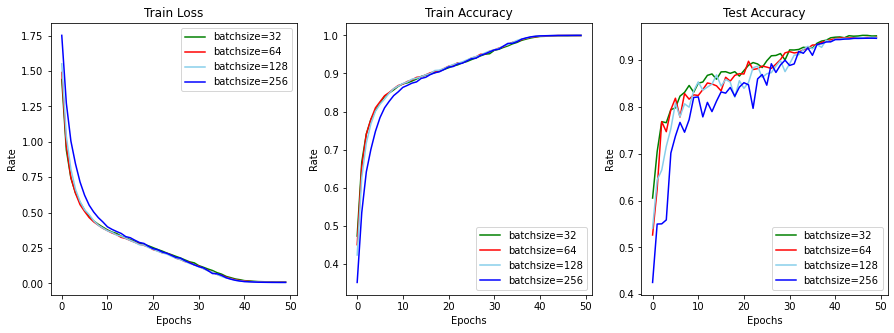

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)

plt.title('Train Loss')
plt.plot(best[0],best[1],color='green',label='batchsize=32')
plt.plot(bs_64new[0],bs_64new[1],color='red',label='batchsize=64')
plt.plot(bs_128new[0],bs_128new[1],color='skyblue',label='batchsize=128')
plt.plot(bs_256new[0],bs_256new[1],color='blue',label='batchsize=256')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Rate')

plt.subplot(1,3,2)

plt.title('Train Accuracy')
plt.plot(best[0],best[2],color='green',label='batchsize=32')
plt.plot(bs_64new[0],bs_64new[2],color='red',label='batchsize=64')
plt.plot(bs_128new[0],bs_128new[2],color='skyblue',label='batchsize=128')
plt.plot(bs_256new[0],bs_256new[2],color='blue',label='batchsize=256')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Rate')

plt.subplot(1,3,3)

plt.title('Test Accuracy')
plt.plot(best[0],best[3],color='green',label='batchsize=32')
plt.plot(bs_64new[0],bs_64new[3],color='red',label='batchsize=64')
plt.plot(bs_128new[0],bs_128new[3],color='skyblue',label='batchsize=128')
plt.plot(bs_256new[0],bs_256new[3],color='blue',label='batchsize=256')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Rate')

plt.show()

In [26]:
bs256_noc=np.array([
    0,1.4719,0.4568,0.5215
,1,1.0025,0.6425,0.5925
,2,0.7999,0.7177,0.7106
,3,0.6676,0.7679,0.7117
,4,0.5796,0.7960,0.7808
,5,0.5225,0.8193,0.7689
,6,0.4706,0.8372,0.7833
,7,0.4373,0.8478,0.7565
,8,0.4069,0.8600,0.8322
,9,0.3780,0.8702,0.8236
,10,0.3565,0.8779,0.8249
,11,0.3325,0.8850,0.7323
,12,0.3146,0.8920,0.8208
,13,0.2977,0.8976,0.8399
,14,0.2844,0.9016,0.8665
,15,0.2657,0.9084,0.8135
,16,0.2513,0.9126,0.8478
,17,0.2432,0.9167,0.8588
,18,0.2289,0.9201,0.8135
,19,0.2177,0.9255,0.8466
,20,0.2128,0.9276,0.8546
,21,0.1983,0.9317,0.8778
,22,0.1928,0.9327,0.8899
,23,0.1832,0.9360,0.8474
,24,0.1757,0.9406,0.8579
,25,0.1685,0.9424,0.8683
,26,0.1607,0.9450,0.8753
,27,0.1548,0.9469,0.8619
,28,0.1498,0.9486,0.8810
,29,0.1433,0.9520,0.8573
,30,0.1412,0.9515,0.8869
,31,0.1371,0.9528,0.8896
,32,0.1298,0.9556,0.8939
,33,0.1259,0.9578,0.8482
,34,0.1192,0.9598,0.8731
,35,0.1160,0.9613,0.8865
,36,0.1141,0.9610,0.8588
,37,0.1112,0.9629,0.8392
,38,0.1059,0.9653,0.8767
,39,0.0953,0.9695,0.8765
,40,0.1012,0.9664,0.8803
,41,0.0919,0.9704,0.8959
,42,0.0916,0.9705,0.8766
,43,0.0859,0.9719,0.8810
,44,0.0858,0.9724,0.8766
,45,0.0871,0.9719,0.8764
,46,0.0853,0.9725,0.8940
,47,0.0883,0.9711,0.8604
,48,0.0797,0.9748,0.8888
,49,0.0860,0.9727,0.8898

])

In [27]:
bs256_noc=bs256_noc.reshape(50,4)
bs256_noc=bs256_noc.T

In [28]:
bs128_noc=np.array([
    0,1.4228,0.4765,0.5623
,1,0.9493,0.6640,0.6750
,2,0.7523,0.7337,0.7291
,3,0.6285,0.7807,0.7509
,4,0.5507,0.8093,0.7903
,5,0.4959,0.8308,0.7472
,6,0.4502,0.8444,0.7815
,7,0.4169,0.8556,0.8183
,8,0.3871,0.8671,0.7978
,9,0.3635,0.8744,0.8447
,10,0.3394,0.8846,0.7932
,11,0.3215,0.8895,0.8437
,12,0.3077,0.8945,0.8249
,13,0.2904,0.8993,0.8454
,14,0.2721,0.9075,0.8670
,15,0.2620,0.9104,0.8337
,16,0.2533,0.9137,0.8558
,17,0.2406,0.9174,0.8616
,18,0.2278,0.9228,0.8744
,19,0.2230,0.9240,0.8505
,20,0.2162,0.9262,0.8602
,21,0.2018,0.9320,0.8909
,22,0.1947,0.9338,0.8403
,23,0.1877,0.9355,0.8778
,24,0.1833,0.9376,0.8798
,25,0.1756,0.9407,0.8782
,26,0.1719,0.9417,0.8730
,27,0.1641,0.9442,0.8720
,28,0.1615,0.9461,0.8881
,29,0.1575,0.9472,0.8712
,30,0.1518,0.9493,0.8924
,31,0.1479,0.9507,0.8926
,32,0.1454,0.9510,0.8928
,33,0.1418,0.9521,0.8805
,34,0.1375,0.9547,0.9010
,35,0.1320,0.9568,0.8982
,36,0.1364,0.9544,0.9009
,37,0.1274,0.9579,0.8917
,38,0.1328,0.9560,0.8967
,39,0.1326,0.9566,0.8971
,40,0.1263,0.9584,0.8993
,41,0.1295,0.9578,0.8704
,42,0.1216,0.9600,0.9035
,43,0.1208,0.9602,0.8783
,44,0.1212,0.9605,0.8910
,45,0.1198,0.9610,0.8944
,46,0.1178,0.9616,0.8812
,47,0.1142,0.9636,0.8853
,48,0.1133,0.9626,0.8883
,49,0.1191,0.9605,0.8875

])

In [29]:
bs128_noc=bs128_noc.reshape(50,4)
bs128_noc=bs128_noc.T

In [30]:
bs32_noc=np.array([
    0,1.4739,0.4591,0.6027
,1,0.9767,0.6528,0.6630
,2,0.7675,0.7304,0.6883
,3,0.6559,0.7737,0.7528
,4,0.5789,0.8023,0.7983
,5,0.5248,0.8202,0.7623
,6,0.4902,0.8345,0.8266
,7,0.4581,0.8421,0.8338
,8,0.4368,0.8514,0.8270
,9,0.4167,0.8592,0.8583
,10,0.4086,0.8604,0.8439
,11,0.3923,0.8686,0.8638
,12,0.3862,0.8691,0.8649
,13,0.3691,0.8759,0.8420
,14,0.3664,0.8760,0.8596
,15,0.3563,0.8793,0.8422
,16,0.3460,0.8825,0.8586
,17,0.3454,0.8827,0.8710
,18,0.3400,0.8860,0.8553
,19,0.3352,0.8855,0.8687
,20,0.3294,0.8879,0.8771
,21,0.3238,0.8907,0.8759
,22,0.3271,0.8906,0.8784
,23,0.3180,0.8928,0.8785
,24,0.3159,0.8939,0.8645
,25,0.3140,0.8942,0.8653
,26,0.3088,0.8965,0.8453
,27,0.3089,0.8950,0.8517
,28,0.3045,0.8969,0.8911
,29,0.2980,0.9002,0.8761
,30,0.3045,0.8979,0.8513
,31,0.3042,0.8968,0.8849
,32,0.2973,0.8995,0.8683
,33,0.2949,0.9006,0.8679
,34,0.2948,0.9024,0.8888
,35,0.2945,0.8999,0.8785
,36,0.2928,0.9014,0.8642
,37,0.2906,0.9016,0.8475
,38,0.2872,0.9029,0.8545
,39,0.2894,0.9022,0.8147
,40,0.2898,0.9028,0.8560
,41,0.2868,0.9026,0.8782
,42,0.2841,0.9033,0.8711
,43,0.2784,0.9067,0.8848
,44,0.2835,0.9041,0.8423
,45,0.2876,0.9013,0.8891
,46,0.2779,0.9060,0.8860
,47,0.2793,0.9053,0.8783
,48,0.2793,0.9051,0.8613
,49,0.2780,0.9064,0.8761

])

In [31]:
bs32_noc=bs32_noc.reshape(50,4)
bs32_noc=bs32_noc.T

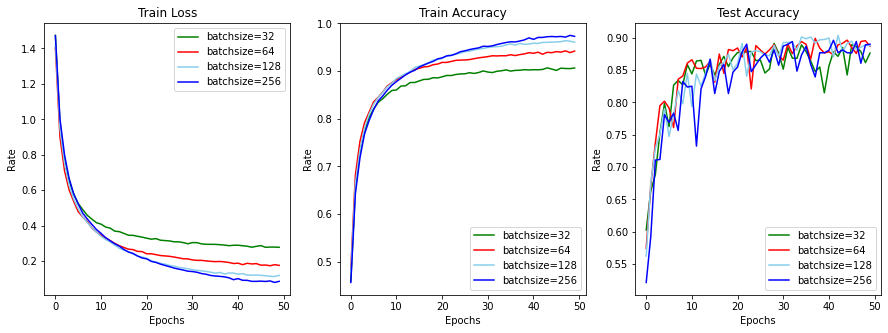

In [32]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)

plt.title('Train Loss')
plt.plot(bs32_noc[0],bs32_noc[1],color='green',label='batchsize=32')
plt.plot(lr_001[0],lr_001[1],color='red',label='batchsize=64')
plt.plot(bs128_noc[0],bs128_noc[1],color='skyblue',label='batchsize=128')
plt.plot(bs256_noc[0],bs256_noc[1],color='blue',label='batchsize=256')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Rate')

plt.subplot(1,3,2)

plt.title('Train Accuracy')
plt.plot(bs32_noc[0],bs32_noc[2],color='green',label='batchsize=32')
plt.plot(lr_001[0],lr_001[2],color='red',label='batchsize=64')
plt.plot(bs128_noc[0],bs128_noc[2],color='skyblue',label='batchsize=128')
plt.plot(bs256_noc[0],bs256_noc[2],color='blue',label='batchsize=256')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Rate')

plt.subplot(1,3,3)

plt.title('Test Accuracy')
plt.plot(bs32_noc[0],bs32_noc[3],color='green',label='batchsize=32')
plt.plot(lr_001[0],lr_001[3],color='red',label='batchsize=64')
plt.plot(bs128_noc[0],bs128_noc[3],color='skyblue',label='batchsize=128')
plt.plot(bs256_noc[0],bs256_noc[3],color='blue',label='batchsize=256')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Rate')

plt.show()